In [214]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import simple_pid
import time

In [202]:
df = pd.read_csv("Step Change SP-25 to SP-454.csv")
df.head()

,Date/Time,COM5.ID001-3216.INPUT.PVInValue,COM5.ID001-3216.SP.WorkingSP,Time(sec),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,5:45:26 PM,25.101299,25,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,5:45:26 PM,25.100105,25,0.869996,NaN,NaN,NaN,NaN,NaN,NaN
2,5:45:28 PM,25.098125,25,1.949996,NaN,NaN,NaN,NaN,NaN,NaN
3,5:45:29 PM,25.097923,25,3.032001,NaN,NaN,NaN,NaN,NaN,NaN
4,5:45:29 PM,25.097923,25,3.032001,NaN,NaN,NaN,NaN,NaN,NaN


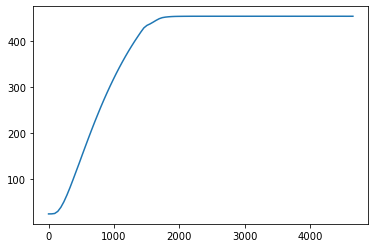

In [203]:
num_pts = 100
up_start = 300
up_end = 5000
up_idx = np.arange(up_start,up_end,(up_end-up_start)//num_pts)
SP_up = df["COM5.ID001-3216.SP.WorkingSP"][up_idx]
PV_up = df["COM5.ID001-3216.INPUT.PVInValue"][up_idx]
Time_up = df["Time(sec)"][up_idx]
Time_up = Time_up-Time_up.iloc[0] #get true start time
Time_up = Time_up.to_numpy()
SP_up = SP_up.to_numpy()
PV_up=PV_up.to_numpy()
plt.plot(Time_up,PV_up)

tau = 4.02e+02 +/- 13.4
damp = 1.0 +/- 0.0366


<ipython-input-205-d733931cd225>:20: RuntimeWarning: invalid value encountered in sqrt
  tau_1 = tau/(damp-np.sqrt(damp**2-1))
<ipython-input-205-d733931cd225>:21: RuntimeWarning: invalid value encountered in sqrt
  tau_2 = tau/(damp+np.sqrt(damp**2-1))


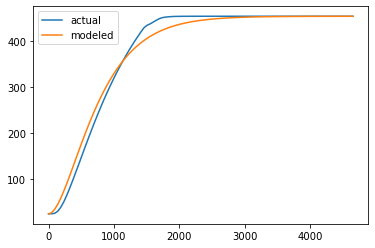

In [205]:
def f(x,b,c):
    #x in seconds, f in degC
    T_start = 25
    return (454-T_start)/(1+np.exp(b-c*x))+T_start

def f2(x,dt,tau_p):
    T_start = 25
    T_sp = 454
    return np.piecewise(x, [x < dt,x >= dt], [lambda x: T_start,lambda x: T_start+(T_sp-T_start)*(1-np.exp(-1*(x-dt)/tau_p))])
#     for xval in x:
#         if xval <= dt:
#             np.append(arr,dt)
#         else:
#             np.append(arr,T_start+kp*(1-np.exp(-1*(xval-dt)/tau_p)))
#     return arr

def f3(x,tau,damp):
    T_start = 25
    T_sp = 454
    tau_1 = tau/(damp-np.sqrt(damp**2-1))
    tau_2 = tau/(damp+np.sqrt(damp**2-1))
    return T_start+(T_sp-T_start)*(1+(tau_1*np.exp(-x/tau_1)-tau_2*np.exp(-x/tau_2))/(tau_2-tau_1))


fx_in_use = "f3"

if fx_in_use == "f":
    popt,pcov= curve_fit(f,Time_up,PV_up)
    sdevs = np.sqrt(np.diag(pcov))
    print("b = {:.3} +/- {:.3}".format(popt[0],sdevs[0]))
    print("c = {:.3} +/- {:.3}".format(popt[1],sdevs[1]))
    PV_modeled = f(Time_up,popt[0],popt[1])
elif fx_in_use == "f2":
    popt,pcov= curve_fit(f2,Time_up,PV_up)
    sdevs = np.sqrt(np.diag(pcov))
    print("dt = {:.3} +/- {:.3}".format(popt[0],sdevs[0]))
    print("tau_p = {:.3} +/- {:.3}".format(popt[1],sdevs[1]))
    tau_p=popt[1]
    dt = popt[0]
    PV_modeled = f2(Time_up,popt[0],popt[1])
elif fx_in_use == "f3":
    popt,pcov= curve_fit(f3,Time_up,PV_up,p0=[400,1.1])
    sdevs = np.sqrt(np.diag(pcov))
    print("tau = {:.3} +/- {:.3}".format(popt[0],sdevs[0]))
    print("damp = {:.3} +/- {:.3}".format(popt[1],sdevs[1]))
    PV_modeled = f3(Time_up,popt[0],popt[1])
else:
    print("oops")
plt.plot(Time_up,PV_up,label="actual")
plt.plot(Time_up,PV_modeled,label="modeled")
plt.legend()
plt.show()

t: 2001 T_sp: 475.0 T_pv: 461.822 New furnace SP: 460.0
11.860538921960677 454.0031628103741
t: 2002 T_sp: 475.0 T_pv: 485.886 New furnace SP: 444.20334
-9.797373191246328 454.000713467074
t: 2003 T_sp: 475.0 T_pv: 471.59 New furnace SP: 457.070406
3.0688744979795217 454.0015318336069
t: 2004 T_sp: 475.0 T_pv: 483.454 New furnace SP: 446.390769
-7.608734306428795 453.99950283779145
t: 2005 T_sp: 475.0 T_pv: 473.601 New furnace SP: 455.259078
1.2592599284642518 453.99981765277323
t: 2006 T_sp: 475.0 T_pv: 481.78 New furnace SP: 447.895924
-6.1022667692471035 453.99819038163446
t: 2007 T_sp: 475.0 T_pv: 474.983 New furnace SP: 454.013075
0.01488029906535644 453.9981943497142
t: 2008 T_sp: 475.0 T_pv: 480.627 New furnace SP: 448.932654
-5.064274251957386 453.99692828115
t: 2009 T_sp: 475.0 T_pv: 475.935 New furnace SP: 453.155418
-0.8412856504331444 453.99670393831025
t: 2010 T_sp: 475.0 T_pv: 479.831 New furnace SP: 449.647384
-4.348233177072558 453.99561688001495
t: 2011 T_sp: 475.0 T_p

t: 2091 T_sp: 475.0 T_pv: 477.939 New furnace SP: 451.293326
-2.6455407880298654 453.9388670302684
t: 2092 T_sp: 475.0 T_pv: 477.938 New furnace SP: 451.29395
-2.644211838319524 453.93816190711135
t: 2093 T_sp: 475.0 T_pv: 477.937 New furnace SP: 451.294515
-2.64298572227417 453.93750116068145
t: 2094 T_sp: 475.0 T_pv: 477.935 New furnace SP: 451.295081
-2.6417155618322967 453.9367967031981
t: 2095 T_sp: 475.0 T_pv: 477.934 New furnace SP: 451.295645
-2.640447888430424 453.9360925837611
t: 2096 T_sp: 475.0 T_pv: 477.932 New furnace SP: 451.296251
-2.639182120756709 453.9354327882303
t: 2097 T_sp: 475.0 T_pv: 477.931 New furnace SP: 451.296772
-2.637957369094778 453.934729332933
t: 2098 T_sp: 475.0 T_pv: 477.93 New furnace SP: 451.297407
-2.636663349233811 453.93407016709506
t: 2099 T_sp: 475.0 T_pv: 477.928 New furnace SP: 451.297897
-2.6354703811580236 453.9333673749933
t: 2100 T_sp: 475.0 T_pv: 477.927 New furnace SP: 451.298507
-2.6341574588638252 453.9326649330041
t: 2101 T_sp: 475

t: 2183 T_sp: 475.0 T_pv: 477.82 New furnace SP: 451.339516
-2.5379680769540016 453.87748382081725
t: 2184 T_sp: 475.0 T_pv: 477.819 New furnace SP: 451.340117
-2.536690314658671 453.87680737006656
t: 2185 T_sp: 475.0 T_pv: 477.818 New furnace SP: 451.340415
-2.5357589188362 453.8761734303363
t: 2186 T_sp: 475.0 T_pv: 477.816 New furnace SP: 451.340926
-2.5345720385757207 453.8754975444604
t: 2187 T_sp: 475.0 T_pv: 477.815 New furnace SP: 451.341295
-2.53356959716607 453.8748641520605
t: 2188 T_sp: 475.0 T_pv: 477.814 New furnace SP: 451.341739
-2.5324500354929795 453.87418883205095
t: 2189 T_sp: 475.0 T_pv: 477.813 New furnace SP: 451.342117
-2.531396636712884 453.8735137929477
t: 2190 T_sp: 475.0 T_pv: 477.811 New furnace SP: 451.342591
-2.5302899331359243 453.87288122046505
t: 2191 T_sp: 475.0 T_pv: 477.81 New furnace SP: 451.342937
-2.5292693890541957 453.87220674862783
t: 2192 T_sp: 475.0 T_pv: 477.809 New furnace SP: 451.343391
-2.528141127476283 453.8715325776604
t: 2193 T_sp: 4

t: 2272 T_sp: 475.0 T_pv: 477.72 New furnace SP: 451.371789
-2.4479379991842793 453.8197270860903
t: 2273 T_sp: 475.0 T_pv: 477.719 New furnace SP: 451.372129
-2.4469865436747513 453.81911533945384
t: 2274 T_sp: 475.0 T_pv: 477.718 New furnace SP: 451.372381
-2.446081903522344 453.8184630509473
t: 2275 T_sp: 475.0 T_pv: 477.717 New furnace SP: 451.372748
-2.445103355714798 453.8178517751078
t: 2276 T_sp: 475.0 T_pv: 477.716 New furnace SP: 451.372972
-2.4442276287250198 453.8171999810733
t: 2277 T_sp: 475.0 T_pv: 477.715 New furnace SP: 451.373319
-2.443229585011528 453.8165484531838
t: 2278 T_sp: 475.0 T_pv: 477.714 New furnace SP: 451.373598
-2.4423400347229687 453.81593786817575
t: 2279 T_sp: 475.0 T_pv: 477.713 New furnace SP: 451.373891
-2.4413955654934627 453.8152868293582
t: 2280 T_sp: 475.0 T_pv: 477.712 New furnace SP: 451.374171
-2.440465169329741 453.8146360386462
t: 2281 T_sp: 475.0 T_pv: 477.711 New furnace SP: 451.374501
-2.4395253327497755 453.81402615731247
t: 2282 T_sp

t: 2363 T_sp: 475.0 T_pv: 477.631 New furnace SP: 451.394585
-2.3681438271074455 453.762728795064
t: 2364 T_sp: 475.0 T_pv: 477.63 New furnace SP: 451.394711
-2.367386567372745 453.7620974919792
t: 2365 T_sp: 475.0 T_pv: 477.629 New furnace SP: 451.39496
-2.3665063764894683 453.76146642361203
t: 2366 T_sp: 475.0 T_pv: 477.629 New furnace SP: 451.395139
-2.365735688463866 453.76087498969054
t: 2367 T_sp: 475.0 T_pv: 477.628 New furnace SP: 451.395337
-2.3649069341073585 453.7602443478413
t: 2368 T_sp: 475.0 T_pv: 477.627 New furnace SP: 451.395518
-2.36409595398718 453.75961392225344
t: 2369 T_sp: 475.0 T_pv: 477.626 New furnace SP: 451.395751
-2.363271747436568 453.75902310431604
t: 2370 T_sp: 475.0 T_pv: 477.625 New furnace SP: 451.395897
-2.3624964749025255 453.7583931052571
t: 2371 T_sp: 475.0 T_pv: 477.624 New furnace SP: 451.396157
-2.361645650187165 453.757802693844
t: 2372 T_sp: 475.0 T_pv: 477.623 New furnace SP: 451.396275
-2.36089811532525 453.7571731210131
t: 2373 T_sp: 475.

t: 2454 T_sp: 475.0 T_pv: 477.554 New furnace SP: 451.408866
-2.298589147060028 453.70745476656685
t: 2455 T_sp: 475.0 T_pv: 477.553 New furnace SP: 451.408985
-2.297856583655198 453.7068420048111
t: 2456 T_sp: 475.0 T_pv: 477.552 New furnace SP: 451.409084
-2.297145031781571 453.7062294328025
t: 2457 T_sp: 475.0 T_pv: 477.552 New furnace SP: 451.409238
-2.2964169223451734 453.70565532857137
t: 2458 T_sp: 475.0 T_pv: 477.551 New furnace SP: 451.409304
-2.2957395026635825 453.70504313137167
t: 2459 T_sp: 475.0 T_pv: 477.55 New furnace SP: 451.409484
-2.2949851886260717 453.704469385074
t: 2460 T_sp: 475.0 T_pv: 477.549 New furnace SP: 451.409523
-2.294334565498781 453.70385756252307
t: 2461 T_sp: 475.0 T_pv: 477.548 New furnace SP: 451.409685
-2.293560470359381 453.7032459463975
t: 2462 T_sp: 475.0 T_pv: 477.548 New furnace SP: 451.409776
-2.2928967865811614 453.70267272220144
t: 2463 T_sp: 475.0 T_pv: 477.547 New furnace SP: 451.409889
-2.292172123416998 453.70206147630176
t: 2464 T_sp

t: 2545 T_sp: 475.0 T_pv: 477.486 New furnace SP: 451.416452
-2.2378339946112478 453.6542863818348
t: 2546 T_sp: 475.0 T_pv: 477.485 New furnace SP: 451.416831
-2.2368963955078924 453.65372715773543
t: 2547 T_sp: 475.0 T_pv: 477.485 New furnace SP: 451.416573
-2.236557937063492 453.6531307422865
t: 2548 T_sp: 475.0 T_pv: 477.484 New furnace SP: 451.416914
-2.2356579501721057 453.65257182779845
t: 2549 T_sp: 475.0 T_pv: 477.484 New furnace SP: 451.416686
-2.2352894111309527 453.65197575062206
t: 2550 T_sp: 475.0 T_pv: 477.483 New furnace SP: 451.416961
-2.2344191393433905 453.6513799055181
t: 2551 T_sp: 475.0 T_pv: 477.482 New furnace SP: 451.416827
-2.2339940688035482 453.6508214070015
t: 2552 T_sp: 475.0 T_pv: 477.481 New furnace SP: 451.417016
-2.233210307664206 453.6502258842527
t: 2553 T_sp: 475.0 T_pv: 477.481 New furnace SP: 451.416919
-2.2327118902208496 453.6496304944152
t: 2554 T_sp: 475.0 T_pv: 477.48 New furnace SP: 451.41711
-2.2319626914175785 453.6490725037418
t: 2555 T_s

t: 2635 T_sp: 475.0 T_pv: 477.427 New furnace SP: 451.418437
-2.184060451609014 453.6024976988833
t: 2636 T_sp: 475.0 T_pv: 477.426 New furnace SP: 451.418497
-2.183454427890229 453.6019518352758
t: 2637 T_sp: 475.0 T_pv: 477.426 New furnace SP: 451.418417
-2.1829523205362364 453.6013697146569
t: 2638 T_sp: 475.0 T_pv: 477.425 New furnace SP: 451.418461
-2.182326479712515 453.6007877609289
t: 2639 T_sp: 475.0 T_pv: 477.424 New furnace SP: 451.41843
-2.1818118915388425 453.60024230795653
t: 2640 T_sp: 475.0 T_pv: 477.424 New furnace SP: 451.418428
-2.1812324657347633 453.59966064596557
t: 2641 T_sp: 475.0 T_pv: 477.423 New furnace SP: 451.4184
-2.1806792587168786 453.59907913149647
t: 2642 T_sp: 475.0 T_pv: 477.422 New furnace SP: 451.41843
-2.180104061382099 453.5985341054806
t: 2643 T_sp: 475.0 T_pv: 477.422 New furnace SP: 451.41837
-2.179582389468368 453.597952883511
t: 2644 T_sp: 475.0 T_pv: 477.421 New furnace SP: 451.418426
-2.1789817694126614 453.59740813806815
t: 2645 T_sp: 475

t: 2726 T_sp: 475.0 T_pv: 477.373 New furnace SP: 451.415788
-2.135539001240528 453.55132725936625
t: 2727 T_sp: 475.0 T_pv: 477.372 New furnace SP: 451.415713
-2.135080791665388 453.5507934891689
t: 2728 T_sp: 475.0 T_pv: 477.372 New furnace SP: 451.415668
-2.1345560448811227 453.55022427422347
t: 2729 T_sp: 475.0 T_pv: 477.371 New furnace SP: 451.415595
-2.1340596919045596 453.54965519163886
t: 2730 T_sp: 475.0 T_pv: 477.371 New furnace SP: 451.415583
-2.133539102900386 453.5491218068626
t: 2731 T_sp: 475.0 T_pv: 477.37 New furnace SP: 451.41548
-2.133073270739112 453.5485529873247
t: 2732 T_sp: 475.0 T_pv: 477.369 New furnace SP: 451.415492
-2.1325276298984934 453.5480198554167
t: 2733 T_sp: 475.0 T_pv: 477.369 New furnace SP: 451.415365
-2.132086316021787 453.5474512990657
t: 2734 T_sp: 475.0 T_pv: 477.368 New furnace SP: 451.415362
-2.131520966551483 453.5468828934745
t: 2735 T_sp: 475.0 T_pv: 477.368 New furnace SP: 451.415362
-2.131520966551483 453.5468828934745
t: 2736 T_sp: 47

t: 2818 T_sp: 475.0 T_pv: 477.324 New furnace SP: 451.409529
-2.0917222772413484 453.5012508527342
t: 2819 T_sp: 475.0 T_pv: 477.324 New furnace SP: 451.40948
-2.0912479322367803 453.50072804075063
t: 2820 T_sp: 475.0 T_pv: 477.323 New furnace SP: 451.409341
-2.0908291354100075 453.5001704863154
t: 2821 T_sp: 475.0 T_pv: 477.323 New furnace SP: 451.409318
-2.090330067855672 453.49964790379795
t: 2822 T_sp: 475.0 T_pv: 477.322 New furnace SP: 451.409155
-2.0899352145900933 453.4990905877406
t: 2823 T_sp: 475.0 T_pv: 477.322 New furnace SP: 451.409117
-2.0894165269562452 453.49853341
t: 2824 T_sp: 475.0 T_pv: 477.321 New furnace SP: 451.409002
-2.089009617378264 453.4980111575962
t: 2825 T_sp: 475.0 T_pv: 477.321 New furnace SP: 451.408919
-2.0885349578343892 453.49745421494066
t: 2826 T_sp: 475.0 T_pv: 477.32 New furnace SP: 451.408807
-2.0880904380063385 453.49689739082373
t: 2827 T_sp: 475.0 T_pv: 477.32 New furnace SP: 451.408756
-2.087619834596683 453.4963754858646
t: 2828 T_sp: 475

t: 2909 T_sp: 475.0 T_pv: 477.28 New furnace SP: 451.400106
-2.0520868607361535 453.4521933420288
t: 2910 T_sp: 475.0 T_pv: 477.28 New furnace SP: 451.399916
-2.0517304491957704 453.45164621390893
t: 2911 T_sp: 475.0 T_pv: 477.279 New furnace SP: 451.399849
-2.0512504647659173 453.45109921378486
t: 2912 T_sp: 475.0 T_pv: 477.279 New furnace SP: 451.399704
-2.050882177009811 453.45058649324113
t: 2913 T_sp: 475.0 T_pv: 477.278 New furnace SP: 451.399594
-2.050445263853891 453.45003970783733
t: 2914 T_sp: 475.0 T_pv: 477.278 New furnace SP: 451.399453
-2.0500398291691284 453.44949303054943
t: 2915 T_sp: 475.0 T_pv: 477.277 New furnace SP: 451.399374
-2.0496068924514588 453.44898062882584
t: 2916 T_sp: 475.0 T_pv: 477.277 New furnace SP: 451.399204
-2.0492302740519395 453.4484341674203
t: 2917 T_sp: 475.0 T_pv: 477.276 New furnace SP: 451.399149
-2.0487729734778273 453.4479219741765
t: 2918 T_sp: 475.0 T_pv: 477.276 New furnace SP: 451.398956
-2.048419726318252 453.44737572891603
t: 2919 

t: 2999 T_sp: 475.0 T_pv: 477.24 New furnace SP: 451.388313
-2.0161899341417153 453.4045026154846
t: 3000 T_sp: 475.0 T_pv: 477.24 New furnace SP: 451.388145
-2.0158539711386085 453.4039986519923
t: 3001 T_sp: 475.0 T_pv: 477.239 New furnace SP: 451.388012
-2.015448801293337 453.4034611989785
t: 3002 T_sp: 475.0 T_pv: 477.239 New furnace SP: 451.387848
-2.0150761451779373 453.40292384533967
t: 3003 T_sp: 475.0 T_pv: 477.239 New furnace SP: 451.387745
-2.01467487294189 453.402420176621
t: 3004 T_sp: 475.0 T_pv: 477.238 New furnace SP: 451.387553
-2.014330361338517 453.40188302185885
t: 3005 T_sp: 475.0 T_pv: 477.238 New furnace SP: 451.387475
-2.013905033500851 453.4013795456
t: 3006 T_sp: 475.0 T_pv: 477.237 New furnace SP: 451.387259
-2.01358342547951 453.40084259001975
t: 3007 T_sp: 475.0 T_pv: 477.237 New furnace SP: 451.387167
-2.013138750964316 453.4003057530194
t: 3008 T_sp: 475.0 T_pv: 477.236 New furnace SP: 451.386997
-2.0128054535738102 453.3998025516565
t: 3009 T_sp: 475.0 T

t: 3089 T_sp: 475.0 T_pv: 477.204 New furnace SP: 451.374814
-1.9833692122139668 453.3581827540816
t: 3090 T_sp: 475.0 T_pv: 477.203 New furnace SP: 451.374755
-1.982898983213653 453.3576539810193
t: 3091 T_sp: 475.0 T_pv: 477.203 New furnace SP: 451.374488
-1.982637111444251 453.3571252777895
t: 3092 T_sp: 475.0 T_pv: 477.202 New furnace SP: 451.374442
-1.9821879577329071 453.3566297307996
t: 3093 T_sp: 475.0 T_pv: 477.202 New furnace SP: 451.374163
-1.9819380763416803 453.35610121398014
t: 3094 T_sp: 475.0 T_pv: 477.202 New furnace SP: 451.374127
-1.9814791791267965 453.3556058441849
t: 3095 T_sp: 475.0 T_pv: 477.201 New furnace SP: 451.373838
-1.9812391410155783 453.3550775137472
t: 3096 T_sp: 475.0 T_pv: 477.201 New furnace SP: 451.373777
-1.9807724310424077 453.35454930776547
t: 3097 T_sp: 475.0 T_pv: 477.201 New furnace SP: 451.373544
-1.9805106020347296 453.35405418011544
t: 3098 T_sp: 475.0 T_pv: 477.2 New furnace SP: 451.373432
-1.980094484360319 453.3535261549195
t: 3099 T_sp

t: 3178 T_sp: 475.0 T_pv: 477.17 New furnace SP: 451.359811
-1.9527542295040405 453.31256508775385
t: 3179 T_sp: 475.0 T_pv: 477.169 New furnace SP: 451.359612
-1.9524325522063521 453.31204443907313
t: 3180 T_sp: 475.0 T_pv: 477.169 New furnace SP: 451.359476
-1.9520806743612185 453.3115564189041
t: 3181 T_sp: 475.0 T_pv: 477.169 New furnace SP: 451.35925
-1.9517859925038068 453.3110359426403
t: 3182 T_sp: 475.0 T_pv: 477.168 New furnace SP: 451.359137
-1.9514106455836442 453.3105480899784
t: 3183 T_sp: 475.0 T_pv: 477.168 New furnace SP: 451.35889
-1.9511380448509499 453.3100277864997
t: 3184 T_sp: 475.0 T_pv: 477.167 New furnace SP: 451.358764
-1.9507436608401123 453.30950758819
t: 3185 T_sp: 475.0 T_pv: 477.167 New furnace SP: 451.35856
-1.9504596801105436 453.30901997327044
t: 3186 T_sp: 475.0 T_pv: 477.167 New furnace SP: 451.358394
-1.950105922924081 453.3084999450242
t: 3187 T_sp: 475.0 T_pv: 477.166 New furnace SP: 451.358194
-1.9497861571367026 453.30798000204885
t: 3188 T_sp:

t: 3269 T_sp: 475.0 T_pv: 477.137 New furnace SP: 451.343428
-1.9232109226414935 453.26663911228064
t: 3270 T_sp: 475.0 T_pv: 477.137 New furnace SP: 451.342753
-1.923404933899343 453.2661582610467
t: 3271 T_sp: 475.0 T_pv: 477.136 New furnace SP: 451.342992
-1.9226538464864065 453.2656455533542
t: 3272 T_sp: 475.0 T_pv: 477.136 New furnace SP: 451.342404
-1.9227283995209745 453.2651328257809
t: 3273 T_sp: 475.0 T_pv: 477.136 New furnace SP: 451.342595
-1.9220569872656712 453.2646523115346
t: 3274 T_sp: 475.0 T_pv: 477.136 New furnace SP: 451.34205
-1.922089330702579 453.26413975437964
t: 3275 T_sp: 475.0 T_pv: 477.135 New furnace SP: 451.342171
-1.9214568254114794 453.2636273658928
t: 3276 T_sp: 475.0 T_pv: 477.135 New furnace SP: 451.341721
-1.9214257209669428 453.2631470094621
t: 3277 T_sp: 475.0 T_pv: 477.134 New furnace SP: 451.341754
-1.920880357473851 453.2626347747009
t: 3278 T_sp: 475.0 T_pv: 477.134 New furnace SP: 451.341383
-1.9207712364096665 453.26215458189137
t: 3279 T_s

t: 3359 T_sp: 475.0 T_pv: 477.107 New furnace SP: 451.326032
-1.8963675706130403 453.2223991569685
t: 3360 T_sp: 475.0 T_pv: 477.107 New furnace SP: 451.325764
-1.8961295664182047 453.22189352241736
t: 3361 T_sp: 475.0 T_pv: 477.106 New furnace SP: 451.325616
-1.8957714900802671 453.2213879833532
t: 3362 T_sp: 475.0 T_pv: 477.106 New furnace SP: 451.325392
-1.8955223901427132 453.2209141027562
t: 3363 T_sp: 475.0 T_pv: 477.106 New furnace SP: 451.325205
-1.8952036565956634 453.22040871511433
t: 3364 T_sp: 475.0 T_pv: 477.105 New furnace SP: 451.324984
-1.894919600589759 453.2199034032207
t: 3365 T_sp: 475.0 T_pv: 477.105 New furnace SP: 451.324825
-1.894604487615402 453.2194297520984
t: 3366 T_sp: 475.0 T_pv: 477.105 New furnace SP: 451.324578
-1.8943464420795124 453.218924593048
t: 3367 T_sp: 475.0 T_pv: 477.104 New furnace SP: 451.324443
-1.894008431973822 453.21845109093954
t: 3368 T_sp: 475.0 T_pv: 477.104 New furnace SP: 451.324174
-1.8937717384744872 453.2179460851425
t: 3369 T_s

-1.8707556716490614 453.17873765368495
t: 3449 T_sp: 475.0 T_pv: 477.078 New furnace SP: 451.307827
-1.8704118458903622 453.1782388771926
t: 3450 T_sp: 475.0 T_pv: 477.078 New furnace SP: 451.307595
-1.8701762042006749 453.177771333142
t: 3451 T_sp: 475.0 T_pv: 477.078 New furnace SP: 451.307402
-1.8698711456333912 453.1772727008364
t: 3452 T_sp: 475.0 T_pv: 477.077 New furnace SP: 451.307173
-1.8696009457328444 453.1767741405841
t: 3453 T_sp: 475.0 T_pv: 477.077 New furnace SP: 451.307007
-1.8692994521366757 453.17630681572064
t: 3454 T_sp: 475.0 T_pv: 477.077 New furnace SP: 451.306754
-1.8690548452633722 453.17580840109605
t: 3455 T_sp: 475.0 T_pv: 477.076 New furnace SP: 451.30661
-1.8687307200996202 453.1753412184156
t: 3456 T_sp: 475.0 T_pv: 477.076 New furnace SP: 451.306336
-1.8685071489835423 453.17484294984246
t: 3457 T_sp: 475.0 T_pv: 477.076 New furnace SP: 451.30618
-1.8681645170440049 453.1743447726378
t: 3458 T_sp: 475.0 T_pv: 477.075 New furnace SP: 451.305948
-1.867929

t: 3540 T_sp: 475.0 T_pv: 477.051 New furnace SP: 451.289092
-1.8456122382906415 453.1347042807537
t: 3541 T_sp: 475.0 T_pv: 477.05 New furnace SP: 451.288856
-1.845355773622464 453.13421218588064
t: 3542 T_sp: 475.0 T_pv: 477.05 New furnace SP: 451.288686
-1.8450644281678479 453.13375091977315
t: 3543 T_sp: 475.0 T_pv: 477.05 New furnace SP: 451.288426
-1.8448328431218728 453.1332589643491
t: 3544 T_sp: 475.0 T_pv: 477.049 New furnace SP: 451.288278
-1.8445194186027152 453.13279783449406
t: 3545 T_sp: 475.0 T_pv: 477.049 New furnace SP: 451.287998
-1.8443083047578455 453.132306018946
t: 3546 T_sp: 475.0 T_pv: 477.049 New furnace SP: 451.287837
-1.8439767943536935 453.1318142918007
t: 3547 T_sp: 475.0 T_pv: 477.049 New furnace SP: 451.287599
-1.843754636069707 453.1313533531422
t: 3548 T_sp: 475.0 T_pv: 477.048 New furnace SP: 451.2874
-1.8434614968546101 453.1308617634096
t: 3549 T_sp: 475.0 T_pv: 477.048 New furnace SP: 451.287165
-1.8432050278997623 453.13037024206875
t: 3550 T_sp: 

t: 3630 T_sp: 475.0 T_pv: 477.024 New furnace SP: 451.269907
-1.8218318843450447 453.0917386536128
t: 3631 T_sp: 475.0 T_pv: 477.024 New furnace SP: 451.269644
-1.8216085679684284 453.0912528913288
t: 3632 T_sp: 475.0 T_pv: 477.024 New furnace SP: 451.269491
-1.8213068351538482 453.0907975646196
t: 3633 T_sp: 475.0 T_pv: 477.023 New furnace SP: 451.269208
-1.8211039741620993 453.09031193689304
t: 3634 T_sp: 475.0 T_pv: 477.023 New furnace SP: 451.269042
-1.8207840957302608 453.0898263944674
t: 3635 T_sp: 475.0 T_pv: 477.023 New furnace SP: 451.268801
-1.8205705335505058 453.0893712518345
t: 3636 T_sp: 475.0 T_pv: 477.023 New furnace SP: 451.268598
-1.820288313429262 453.08888584161747
t: 3637 T_sp: 475.0 T_pv: 477.022 New furnace SP: 451.268359
-1.820041004267415 453.08840049734954
t: 3638 T_sp: 475.0 T_pv: 477.022 New furnace SP: 451.268183
-1.819762239092529 453.08794555678935
t: 3639 T_sp: 475.0 T_pv: 477.022 New furnace SP: 451.267921
-1.819539737938618 453.0874603461933
t: 3640 T_

t: 3720 T_sp: 475.0 T_pv: 476.999 New furnace SP: 451.250408
-1.798911623795658 453.0493195693446
t: 3721 T_sp: 475.0 T_pv: 476.999 New furnace SP: 451.250123
-1.7987168805974763 453.0488399115097
t: 3722 T_sp: 475.0 T_pv: 476.998 New furnace SP: 451.249954
-1.7984061964871274 453.04836033652384
t: 3723 T_sp: 475.0 T_pv: 476.998 New furnace SP: 451.24971
-1.7982008736954243 453.04791078630586
t: 3724 T_sp: 475.0 T_pv: 476.998 New furnace SP: 451.249504
-1.7979273564992297 453.0474313390107
t: 3725 T_sp: 475.0 T_pv: 476.997 New furnace SP: 451.249263
-1.7976886642412582 453.0469519553668
t: 3726 T_sp: 475.0 T_pv: 476.997 New furnace SP: 451.249084
-1.797418553405339 453.04650260072805
t: 3727 T_sp: 475.0 T_pv: 476.997 New furnace SP: 451.248819
-1.7972043268828146 453.04602334624167
t: 3728 T_sp: 475.0 T_pv: 476.997 New furnace SP: 451.248662
-1.7969123670058422 453.0455741181495
t: 3729 T_sp: 475.0 T_pv: 476.996 New furnace SP: 451.248377
-1.7967183027405385 453.04509499326866
t: 3730 

t: 3811 T_sp: 475.0 T_pv: 476.974 New furnace SP: 451.230417
-1.7765377464899188 453.00695458555174
t: 3812 T_sp: 475.0 T_pv: 476.974 New furnace SP: 451.230209
-1.776271848523976 453.0064809130587
t: 3813 T_sp: 475.0 T_pv: 476.973 New furnace SP: 451.229967
-1.776040637115301 453.00600730222203
t: 3814 T_sp: 475.0 T_pv: 476.973 New furnace SP: 451.229785
-1.7757780991313723 453.0055633576968
t: 3815 T_sp: 475.0 T_pv: 476.973 New furnace SP: 451.229519
-1.7755710278632593 453.00508987209014
t: 3816 T_sp: 475.0 T_pv: 476.973 New furnace SP: 451.229359
-1.77528688462898 453.0046460503686
t: 3817 T_sp: 475.0 T_pv: 476.972 New furnace SP: 451.229073
-1.7750997183805794 453.00417269044357
t: 3818 T_sp: 475.0 T_pv: 476.972 New furnace SP: 451.228902
-1.7747978124210704 453.00369941102684
t: 3819 T_sp: 475.0 T_pv: 476.972 New furnace SP: 451.228656
-1.7746001962756963 453.0032557609782
t: 3820 T_sp: 475.0 T_pv: 476.971 New furnace SP: 451.228448
-1.7743349438347822 453.0027826049931
t: 3821 T

t: 3902 T_sp: 475.0 T_pv: 476.95 New furnace SP: 451.210562
-1.7549894919186728 452.9655516432123
t: 3903 T_sp: 475.0 T_pv: 476.95 New furnace SP: 451.210378
-1.7547347199429453 452.9651129595319
t: 3904 T_sp: 475.0 T_pv: 476.949 New furnace SP: 451.210112
-1.7545329656373951 452.96464508407513
t: 3905 T_sp: 475.0 T_pv: 476.949 New furnace SP: 451.20995
-1.7542566437881022 452.9642065199138
t: 3906 T_sp: 475.0 T_pv: 476.949 New furnace SP: 451.209664
-1.7540747139182258 452.96373876665666
t: 3907 T_sp: 475.0 T_pv: 476.949 New furnace SP: 451.20949
-1.7537806606661037 452.96327109181374
t: 3908 T_sp: 475.0 T_pv: 476.948 New furnace SP: 451.209244
-1.7535885355278027 452.9628326946803
t: 3909 T_sp: 475.0 T_pv: 476.948 New furnace SP: 451.209035
-1.7533305570524078 452.96236513986497
t: 3910 T_sp: 475.0 T_pv: 476.948 New furnace SP: 451.208792
-1.7531059464605734 452.9618976449458
t: 3911 T_sp: 475.0 T_pv: 476.948 New furnace SP: 451.208608
-1.752851176170333 452.96145943215134
t: 3912 T_

t: 3992 T_sp: 475.0 T_pv: 476.927 New furnace SP: 451.190618
-1.7340574343485629 452.9246757793142
t: 3993 T_sp: 475.0 T_pv: 476.926 New furnace SP: 451.190456
-1.7337864041026365 452.92424233271277
t: 3994 T_sp: 475.0 T_pv: 476.926 New furnace SP: 451.19017
-1.7336104683952898 452.92378003658774
t: 3995 T_sp: 475.0 T_pv: 476.926 New furnace SP: 451.189996
-1.7333220420279305 452.9233178173764
t: 3996 T_sp: 475.0 T_pv: 476.926 New furnace SP: 451.189749
-1.7331358875592457 452.92288453340495
t: 3997 T_sp: 475.0 T_pv: 476.925 New furnace SP: 451.189539
-1.7328832232535376 452.922422431212
t: 3998 T_sp: 475.0 T_pv: 476.925 New furnace SP: 451.189296
-1.7326648295148346 452.92196038725734
t: 3999 T_sp: 475.0 T_pv: 476.925 New furnace SP: 451.189112
-1.732415434093656 452.9215272833984
t: 4000 T_sp: 475.0 T_pv: 476.925 New furnace SP: 451.188845
-1.732220542922653 452.92106535792107
t: 4001 T_sp: 475.0 T_pv: 476.924 New furnace SP: 451.188682
-1.7319500396666343 452.9206323704108
t: 4002 T

t: 4084 T_sp: 475.0 T_pv: 476.904 New furnace SP: 451.170499
-1.7133285184088436 452.8838279871039
t: 4085 T_sp: 475.0 T_pv: 476.903 New furnace SP: 451.170253
-1.7131471189047602 452.8833997003246
t: 4086 T_sp: 475.0 T_pv: 476.903 New furnace SP: 451.170043
-1.7128997412824505 452.8829429270602
t: 4087 T_sp: 475.0 T_pv: 476.903 New furnace SP: 451.1698
-1.7126864513469002 452.88248621067305
t: 4088 T_sp: 475.0 T_pv: 476.903 New furnace SP: 451.169616
-1.7124423070501338 452.8820581000959
t: 4089 T_sp: 475.0 T_pv: 476.903 New furnace SP: 451.169349
-1.7122522265561202 452.8816014995029
t: 4090 T_sp: 475.0 T_pv: 476.902 New furnace SP: 451.169186
-1.7119872115847954 452.8811735026996
t: 4091 T_sp: 475.0 T_pv: 476.902 New furnace SP: 451.168901
-1.7118162910024297 452.88071701835526
t: 4092 T_sp: 475.0 T_pv: 476.902 New furnace SP: 451.168727
-1.7115340828395176 452.88026060926643
t: 4093 T_sp: 475.0 T_pv: 476.902 New furnace SP: 451.16848
-1.711353062930567 452.87983277100113
t: 4094 T_

-1.6935984667496542 452.84436765429257
t: 4174 T_sp: 475.0 T_pv: 476.882 New furnace SP: 451.15056
-1.6933558980570467 452.84391609271967
t: 4175 T_sp: 475.0 T_pv: 476.881 New furnace SP: 451.150317
-1.6931470897639203 452.843464586829
t: 4176 T_sp: 475.0 T_pv: 476.881 New furnace SP: 451.150134
-1.6929077090762064 452.84304135990135
t: 4177 T_sp: 475.0 T_pv: 476.881 New furnace SP: 451.149868
-1.692721836619785 452.8425899674123
t: 4178 T_sp: 475.0 T_pv: 476.881 New furnace SP: 451.149705
-1.6924618099849624 452.8421668519594
t: 4179 T_sp: 475.0 T_pv: 476.88 New furnace SP: 451.149421
-1.6922948761826035 452.84171557332564
t: 4180 T_sp: 475.0 T_pv: 476.88 New furnace SP: 451.149247
-1.6920178342478664 452.84126436856974
t: 4181 T_sp: 475.0 T_pv: 476.88 New furnace SP: 451.149
-1.691840915486472 452.8408414083413
t: 4182 T_sp: 475.0 T_pv: 476.88 New furnace SP: 451.148792
-1.691598758943411 452.8403903153388
t: 4183 T_sp: 475.0 T_pv: 476.879 New furnace SP: 451.148549
-1.69139033768358

t: 4265 T_sp: 475.0 T_pv: 476.86 New furnace SP: 451.130721
-1.673747012172538 452.8044679014502
t: 4266 T_sp: 475.0 T_pv: 476.86 New furnace SP: 451.130456
-1.6735660718408156 452.8040216171651
t: 4267 T_sp: 475.0 T_pv: 476.859 New furnace SP: 451.130294
-1.6733095944926049 452.8036032897661
t: 4268 T_sp: 475.0 T_pv: 476.859 New furnace SP: 451.13001
-1.6731471785482313 452.80315711718504
t: 4269 T_sp: 475.0 T_pv: 476.859 New furnace SP: 451.129837
-1.6728740429072786 452.8027110174402
t: 4270 T_sp: 475.0 T_pv: 476.859 New furnace SP: 451.129591
-1.6727015911039131 452.80229284204285
t: 4271 T_sp: 475.0 T_pv: 476.858 New furnace SP: 451.129384
-1.6724630830777585 452.80184685188726
t: 4272 T_sp: 475.0 T_pv: 476.858 New furnace SP: 451.129142
-1.6722593417255212 452.80140091606273
t: 4273 T_sp: 475.0 T_pv: 476.858 New furnace SP: 451.128959
-1.6720240998555311 452.80098291003736
t: 4274 T_sp: 475.0 T_pv: 476.858 New furnace SP: 451.128694
-1.6718428897773436 452.8005370852675
t: 4275 T

t: 4355 T_sp: 475.0 T_pv: 476.838 New furnace SP: 451.110959
-1.6545150934298705 452.76547440914135
t: 4356 T_sp: 475.0 T_pv: 476.838 New furnace SP: 451.110678
-1.6543549813778953 452.7650332478129
t: 4357 T_sp: 475.0 T_pv: 476.838 New furnace SP: 451.110505
-1.6540870424576155 452.7645921579348
t: 4358 T_sp: 475.0 T_pv: 476.838 New furnace SP: 451.110262
-1.653917162758495 452.76417867864456
t: 4359 T_sp: 475.0 T_pv: 476.837 New furnace SP: 451.110054
-1.6536833114977583 452.76373769642805
t: 4360 T_sp: 475.0 T_pv: 476.837 New furnace SP: 451.109814
-1.6534826154394069 452.76329676773054
t: 4361 T_sp: 475.0 T_pv: 476.837 New furnace SP: 451.109632
-1.6532518727227739 452.76288345476195
t: 4362 T_sp: 475.0 T_pv: 476.837 New furnace SP: 451.109369
-1.6530735538189902 452.7624426351483
t: 4363 T_sp: 475.0 T_pv: 476.836 New furnace SP: 451.109207
-1.652822635068253 452.7620294294892
t: 4364 T_sp: 475.0 T_pv: 476.836 New furnace SP: 451.108926
-1.6526628004498036 452.76158871940896
t: 436

t: 4447 T_sp: 475.0 T_pv: 476.817 New furnace SP: 451.091046
-1.6354450513980738 452.7264913042364
t: 4448 T_sp: 475.0 T_pv: 476.817 New furnace SP: 451.09084
-1.6352152770048463 452.7260552468291
t: 4449 T_sp: 475.0 T_pv: 476.817 New furnace SP: 451.090602
-1.6350176137922006 452.725619242132
t: 4450 T_sp: 475.0 T_pv: 476.816 New furnace SP: 451.09042
-1.6347908440541346 452.7252105444206
t: 4451 T_sp: 475.0 T_pv: 476.816 New furnace SP: 451.090159
-1.6346153617806352 452.7247746469915
t: 4452 T_sp: 475.0 T_pv: 476.816 New furnace SP: 451.089997
-1.6343685807647887 452.7243660548459
t: 4453 T_sp: 475.0 T_pv: 476.816 New furnace SP: 451.089719
-1.6342114230751237 452.723930265133
t: 4454 T_sp: 475.0 T_pv: 476.815 New furnace SP: 451.089546
-1.6339481349465188 452.7234945456303
t: 4455 T_sp: 475.0 T_pv: 476.815 New furnace SP: 451.089305
-1.6337813675923145 452.7230861002888
t: 4456 T_sp: 475.0 T_pv: 476.815 New furnace SP: 451.089099
-1.633551707770863 452.72265048649996
t: 4457 T_sp: 

t: 4537 T_sp: 475.0 T_pv: 476.797 New furnace SP: 451.071509
-1.616852461381251 452.6883613606963
t: 4538 T_sp: 475.0 T_pv: 476.796 New furnace SP: 451.071328
-1.6166287686077625 452.6879572035038
t: 4539 T_sp: 475.0 T_pv: 476.796 New furnace SP: 451.07107
-1.6164564432172484 452.68752614845295
t: 4540 T_sp: 475.0 T_pv: 476.796 New furnace SP: 451.070909
-1.616213012486162 452.68712209519947
t: 4541 T_sp: 475.0 T_pv: 476.796 New furnace SP: 451.070632
-1.616058754980628 452.68669114619803
t: 4542 T_sp: 475.0 T_pv: 476.795 New furnace SP: 451.070461
-1.6157990395489776 452.68626026645404
t: 4543 T_sp: 475.0 T_pv: 476.795 New furnace SP: 451.070221
-1.6156352358145227 452.6858563576455
t: 4544 T_sp: 475.0 T_pv: 476.795 New furnace SP: 451.070017
-1.6154088079690383 452.6854255819633
t: 4545 T_sp: 475.0 T_pv: 476.795 New furnace SP: 451.06978
-1.6152148873137093 452.6849948579932
t: 4546 T_sp: 475.0 T_pv: 476.794 New furnace SP: 451.0696
-1.6149914926265638 452.6845911101197
t: 4547 T_sp:

t: 4629 T_sp: 475.0 T_pv: 476.776 New furnace SP: 451.051964
-1.5983274440846855 452.65029102677005
t: 4630 T_sp: 475.0 T_pv: 476.776 New furnace SP: 451.051691
-1.5981741400565512 452.64986484699926
t: 4631 T_sp: 475.0 T_pv: 476.775 New furnace SP: 451.051519
-1.5979193923783157 452.6494387351612
t: 4632 T_sp: 475.0 T_pv: 476.775 New furnace SP: 451.051282
-1.597756909536389 452.64903929593424
t: 4633 T_sp: 475.0 T_pv: 476.775 New furnace SP: 451.051078
-1.5975348376896534 452.6486132866441
t: 4634 T_sp: 475.0 T_pv: 476.775 New furnace SP: 451.050845
-1.5973427839553551 452.64818732856827
t: 4635 T_sp: 475.0 T_pv: 476.775 New furnace SP: 451.050665
-1.5971235126103636 452.64778804768974
t: 4636 T_sp: 475.0 T_pv: 476.774 New furnace SP: 451.050409
-1.5969532372432582 452.64736219349385
t: 4637 T_sp: 475.0 T_pv: 476.774 New furnace SP: 451.050249
-1.596714299095322 452.6469630149187
t: 4638 T_sp: 475.0 T_pv: 476.774 New furnace SP: 451.049975
-1.596562019288126 452.6465372650468
t: 4639

t: 4720 T_sp: 475.0 T_pv: 476.756 New furnace SP: 451.032489
-1.580139511250684 452.6126289132062
t: 4721 T_sp: 475.0 T_pv: 476.755 New furnace SP: 451.032288
-1.5799193413673096 452.6122076013818
t: 4722 T_sp: 475.0 T_pv: 476.755 New furnace SP: 451.032055
-1.579731038509152 452.6117863397714
t: 4723 T_sp: 475.0 T_pv: 476.755 New furnace SP: 451.031878
-1.579513832801473 452.61139146131285
t: 4724 T_sp: 475.0 T_pv: 476.755 New furnace SP: 451.031623
-1.5793468863829787 452.6109703021438
t: 4725 T_sp: 475.0 T_pv: 476.755 New furnace SP: 451.031465
-1.5791103896508674 452.61057552454605
t: 4726 T_sp: 475.0 T_pv: 476.754 New furnace SP: 451.031193
-1.5789610914080299 452.6101544682549
t: 4727 T_sp: 475.0 T_pv: 476.754 New furnace SP: 451.031025
-1.5787086739939298 452.60973347927506
t: 4728 T_sp: 475.0 T_pv: 476.754 New furnace SP: 451.030789
-1.5785500454324564 452.6093388417641
t: 4729 T_sp: 475.0 T_pv: 476.754 New furnace SP: 451.030588
-1.5783301442096958 452.60891795372555
t: 4730 T

-1.5625458411996647 452.57620277098687
t: 4810 T_sp: 475.0 T_pv: 476.736 New furnace SP: 451.013426
-1.5623601103317186 452.575786141624
t: 4811 T_sp: 475.0 T_pv: 476.736 New furnace SP: 451.01325
-1.5621457661690499 452.5753956051821
t: 4812 T_sp: 475.0 T_pv: 476.736 New furnace SP: 451.01325
-1.5621457661690499 452.5753956051821
t: 4813 T_sp: 475.0 T_pv: 476.736 New furnace SP: 451.013002
-1.561976714577611 452.5749790780589
t: 4814 T_sp: 475.0 T_pv: 476.735 New furnace SP: 451.012841
-1.5617473348877127 452.5745886412248
t: 4815 T_sp: 475.0 T_pv: 476.735 New furnace SP: 451.012576
-1.5615965080940215 452.5741722154892
t: 4816 T_sp: 475.0 T_pv: 476.735 New furnace SP: 451.012405
-1.561350677207929 452.57375585530855
t: 4817 T_sp: 475.0 T_pv: 476.735 New furnace SP: 451.012174
-1.5611912596947548 452.573365557494
t: 4818 T_sp: 475.0 T_pv: 476.734 New furnace SP: 451.011972
-1.5609770047766405 452.57294929695934
t: 4819 T_sp: 475.0 T_pv: 476.734 New furnace SP: 451.011744
-1.5607890002

t: 4901 T_sp: 475.0 T_pv: 476.716 New furnace SP: 450.99454
-1.5448429525544385 452.5393831813295
t: 4902 T_sp: 475.0 T_pv: 476.716 New furnace SP: 450.994385
-1.5446124801535177 452.5389970282091
t: 4903 T_sp: 475.0 T_pv: 476.716 New furnace SP: 450.994118
-1.5444673448649497 452.53858517025037
t: 4904 T_sp: 475.0 T_pv: 476.716 New furnace SP: 450.993952
-1.5442212932633026 452.5381733779054
t: 4905 T_sp: 475.0 T_pv: 476.716 New furnace SP: 450.99372
-1.5440670294631047 452.53778736114845
t: 4906 T_sp: 475.0 T_pv: 476.715 New furnace SP: 450.993523
-1.5438527789902536 452.53737566707395
t: 4907 T_sp: 475.0 T_pv: 476.715 New furnace SP: 450.993294
-1.5436697177767316 452.5369640218158
t: 4908 T_sp: 475.0 T_pv: 476.715 New furnace SP: 450.99312
-1.5434583620532294 452.5365781572249
t: 4909 T_sp: 475.0 T_pv: 476.715 New furnace SP: 450.99287
-1.5432961636531617 452.5361666115819
t: 4910 T_sp: 475.0 T_pv: 476.715 New furnace SP: 450.992715
-1.5430659531010236 452.53578084509326
t: 4911 T_

t: 4993 T_sp: 475.0 T_pv: 476.697 New furnace SP: 450.97567
-1.5273109480704592 452.5029808709371
t: 4994 T_sp: 475.0 T_pv: 476.697 New furnace SP: 450.97544
-1.527158996236534 452.5025990811884
t: 4995 T_sp: 475.0 T_pv: 476.697 New furnace SP: 450.975245
-1.526947146446139 452.5021918952826
t: 4996 T_sp: 475.0 T_pv: 476.696 New furnace SP: 450.975018
-1.5267666604812007 452.50178475750636
t: 4997 T_sp: 475.0 T_pv: 476.696 New furnace SP: 450.974845
-1.5265577184901191 452.5014031180764
t: 4998 T_sp: 475.0 T_pv: 476.696 New furnace SP: 450.974598
-1.52639782347444 452.50099607865747
t: 4999 T_sp: 475.0 T_pv: 476.696 New furnace SP: 450.974444
-1.5261702691450638 452.5006145360898


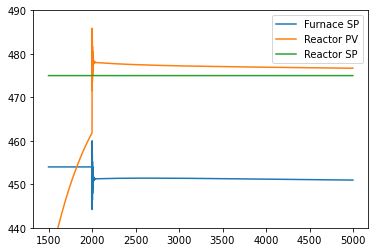

[476.6974413  476.69728256 476.69701216 476.69684333 476.69660794
 476.6964074  476.69617524 476.69599758 476.69574474 476.69558599]


In [221]:
kcrit = 1
pcrit = 800
# kc = .45*kcrit
# ti = pcrit/1.2
# td = 0

kc_mult=2
ki_mult=10

kc= .45*kcrit * kc_mult
ki = 1.2/pcrit * ki_mult
# ki = 10
kd=0


def f_new(t,T_start,T_sp,popt):
    tau=popt[0]
    damp=popt[1]
    tau_1 = tau/(damp-np.sqrt(damp**2-1))
    tau_2 = tau/(damp+np.sqrt(damp**2-1))
    return T_start+(T_sp-T_start)*(1+(tau_1*np.exp(-t/tau_1)-tau_2*np.exp(-t/tau_2))/(tau_2-tau_1))

def disturbance(T):
    if T<=400:
        return 0
    elif 400 < T < 600:
        return .01*T
    else:
        return 6
t_arr = np.arange(0,5000,1)
cascade_SP_arr = np.zeros(len(t_arr))
SP_arr = np.zeros(len(t_arr))

PID = simple_pid.PID(kc,ki,kd)
PID.set_auto_mode(False)
PID.output_limits = (0.0,460.0)

def cascade(t,T_sp,T_pv): #takes an input SP and gives an output SP based on time
    if T_sp < 100:
        return T_sp
    else:
        if t < 2000:
            return T_sp-21
        else:
            if PID.auto_mode != True:
                time.sleep(.01)
                PID.set_auto_mode(True,last_output = T_sp-21)
                PID.setpoint = T_sp
                return(T_sp-21)
            else:
                time.sleep(.01)
                pid_val = PID(T_pv)
                print("t: {} T_sp: {} T_pv: {:.6} New furnace SP: {:.9}".format(t,T_sp,T_pv,pid_val))
                p,i,d=PID.components
                print(p,i)
                return(pid_val) #returns new SP_arr value to provide to furnace controller
            

for n,t in enumerate(t_arr):
    if t <= 50:
        cascade_SP_arr[n] = 25
    else:
        cascade_SP_arr[n] = 475

def convert(T): #convert from a furnace T to a reactor T
    if T < 100:
        return T
    else:
        return T+21
    
def deconvert(T): #convert from a reactor T to a furnace T
    if T < 100:
        return T
    else:
        return T-21
f_arr = np.zeros(len(t_arr))
for n,t in enumerate(t_arr):
    if n==0:
        T_start = 25
        SP_arr[n] = 25
    else:
        SP_arr[n] = cascade(t,cascade_SP_arr[n],f_arr[n-1])
        if SP_arr[n] != SP_arr[n-1]: #made a change in SP
            T_start = f_arr[n-1] #use the prev finish temp as the new start temp
    f_val = f_new(t,T_start,SP_arr[n],popt)
    f_val = convert(f_val)
    f_arr[n] = f_val + disturbance(f_val)

    
# kp=1
# tau_p = tau_p
# dt = dt # from above

# print("Analysis of stability")
# print("---------------------")
# print("Condition 1: ti*tp/(kp*kc) > 0 ? : {}".format(ti*tau_p/(kp*kc) > 0))
# print("Condition 2: ")
n_show = 1500
plt.plot(t_arr[n_show:],SP_arr[n_show:],label="Furnace SP")
plt.plot(t_arr[n_show:],f_arr[n_show:],label="Reactor PV")
plt.plot(t_arr[n_show:],cascade_SP_arr[n_show:],label="Reactor SP")
plt.ylim(440,490)
plt.legend()
plt.show()
print(f_arr[-10:])

In [198]:
PID.__repr__

<bound method PID.__repr__ of PID(Kp=0.7200000000000001, Ki=0.0019500000000000001, Kd=0, setpoint=475.0, sample_time=0.01, output_limits=(None, None), auto_mode=True, proportional_on_measurement=False,error_map=None)>